In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Sequential
from keras.models import load_model
from keras.applications import MobileNet
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
batch_size = 64
dataset_code = 'AIDER'
model_name = 'MobileNet'
data_saved_dir = r'E:\Disaster\AIDER\\pickle\\'
model_saved_dir = r'E:\Disaster\\runs\\'
test_data_path = f'{data_saved_dir}\\test_data.pkl'

In [3]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

test_images, test_labels = load_pickle(test_data_path)
print(f'Testing images: {test_images.shape}')

Testing images: (967, 256, 256, 3)


In [4]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Function to convert labels into one-hot encoding
def one_hot_encode_labels(labels):

    # Fit the label encoder to the labels and transform to integers
    integer_labels = label_encoder.fit_transform(labels)

    # Convert the integer labels into one-hot encoding
    one_hot_labels = np.zeros((len(labels), len(label_encoder.classes_)))
    one_hot_labels[np.arange(len(labels)), integer_labels] = 1

    return one_hot_labels, label_encoder.classes_

test_one_hot, _ = one_hot_encode_labels(test_labels)
print(f"One-hot encoded test labels shape: {test_one_hot.shape}")

One-hot encoded test labels shape: (967, 5)


In [5]:
import numpy as np
from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        """
        Initialize the data generator.

        :param images: Array of image data
        :param labels: One-hot encoded labels
        :param batch_size: The number of samples per batch
        """
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.

        :param index: The batch index
        :return: A batch of images and one-hot encoded labels
        """
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        # Get the images and labels for the batch
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]

        return batch_images, batch_labels

test_data_generator = CustomDataGenerator(test_images, test_one_hot, batch_size=32)

In [6]:
checkpoint = f'{model_saved_dir}\\AIDER_MobileNet/AIDER_MobileNet-weights-improvement-05-0.96.keras'
best_model = load_model(checkpoint)

In [7]:
import tensorflow as tf

tf.__version__

'2.10.0'

In [9]:
from lime import lime_image


def apply_lime(image, label):

    explainer = lime_image.LimeImageExplainer()
    exp = explainer.explain_instance(image, 
                                    best_model.predict, 
                                    top_labels=1, 
                                    hide_color=0, 
                                    num_samples=1000)
    
    temp, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=True, negative_only=False, num_features=5, hide_rest=True)

    img = np.expand_dims(image, axis=0)
    class_labels = ["collapsed_building", "fire", "flooded_areas", "normal", "traffic_incident"]
    
    # Get the prediction probabilities
    predictions = best_model.predict(img)[0]
    
    # Get the predicted class label
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]
    predicted_confidence = round(predictions[predicted_class_index] * 100, 2)

    print(f'Predicted: {predicted_class} with {predicted_confidence}% confidence')

    # Map label to class name for ground truth
    ground_truth = class_labels[label]
    
    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)  
    plt.imshow(image)
    plt.title(f'Original Image \n Ground Truth: {ground_truth}')

    plt.subplot(1, 2, 2)
    dict_heatmap = dict(exp.local_exp[exp.top_labels[0]])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
    plt.colorbar()
    plt.title(f'Heatmap \n Predicted: {predicted_class}')

    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
Predicted: normal with 100.0% confidence


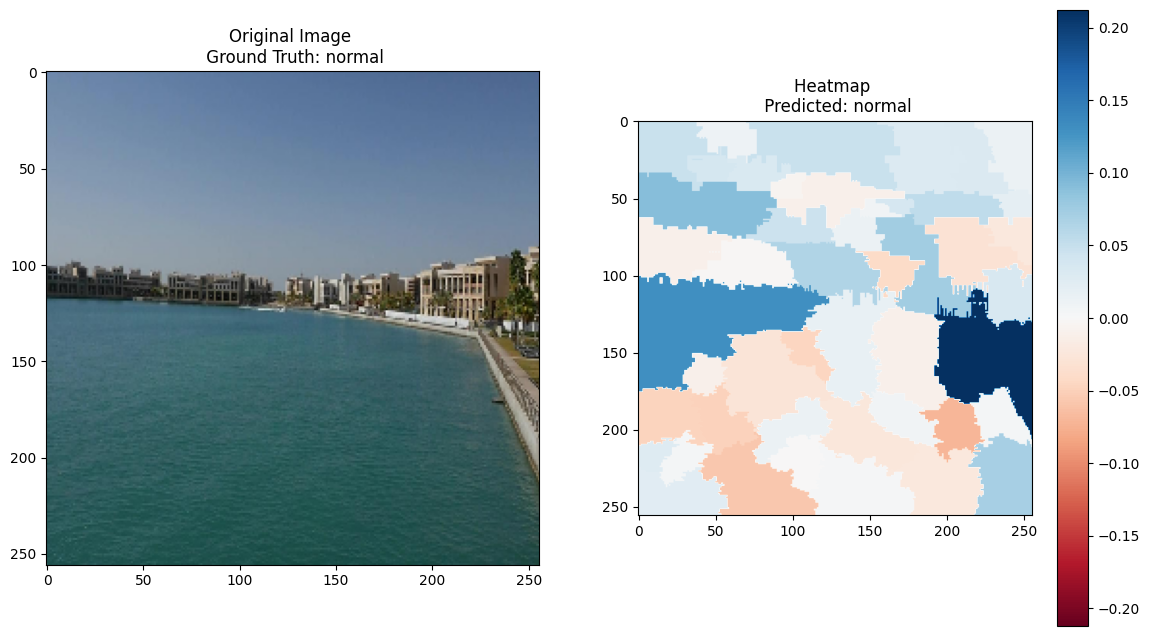

In [13]:
apply_lime(test_images[1], np.argmax(test_one_hot[1]))

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
Predicted: traffic_incident with 100.0% confidence


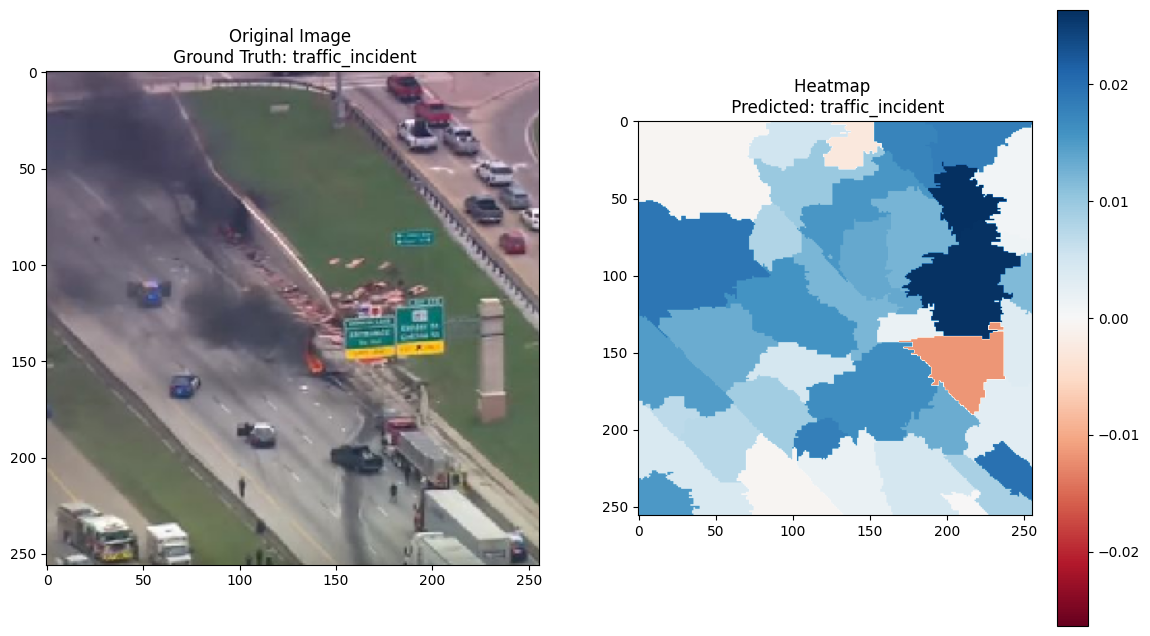

In [17]:
apply_lime(test_images[200], np.argmax(test_one_hot[200]))

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
Predicted: collapsed_building with 100.0% confidence


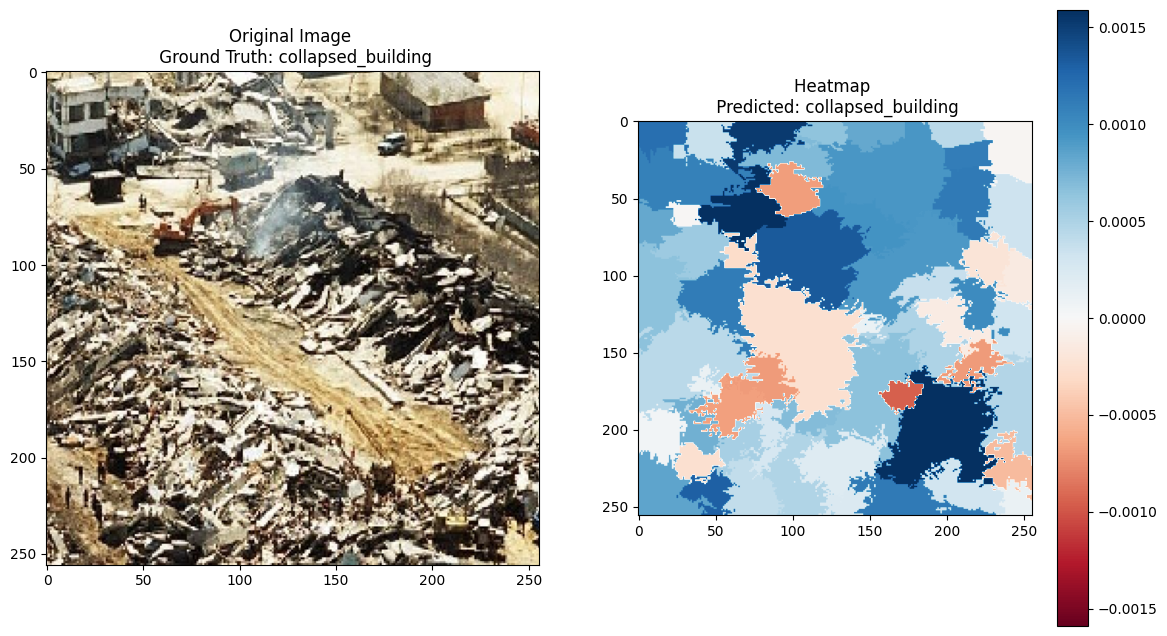

In [22]:
apply_lime(test_images[700], np.argmax(test_one_hot[700]))

In [29]:
label_encoder.classes_

array(['collapsed_building', 'fire', 'flooded_areas', 'normal',
       'traffic_incident'], dtype='<U18')

In [30]:
# filter fire image and flooded_areas image
fire_image = test_images[np.argmax(test_one_hot[:, label_encoder.classes_ == 'fire'])]
flooded_areas_image = test_images[np.argmax(test_one_hot[:, label_encoder.classes_ == 'flooded_areas'])]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step
Predicted: fire with 100.0% confidence


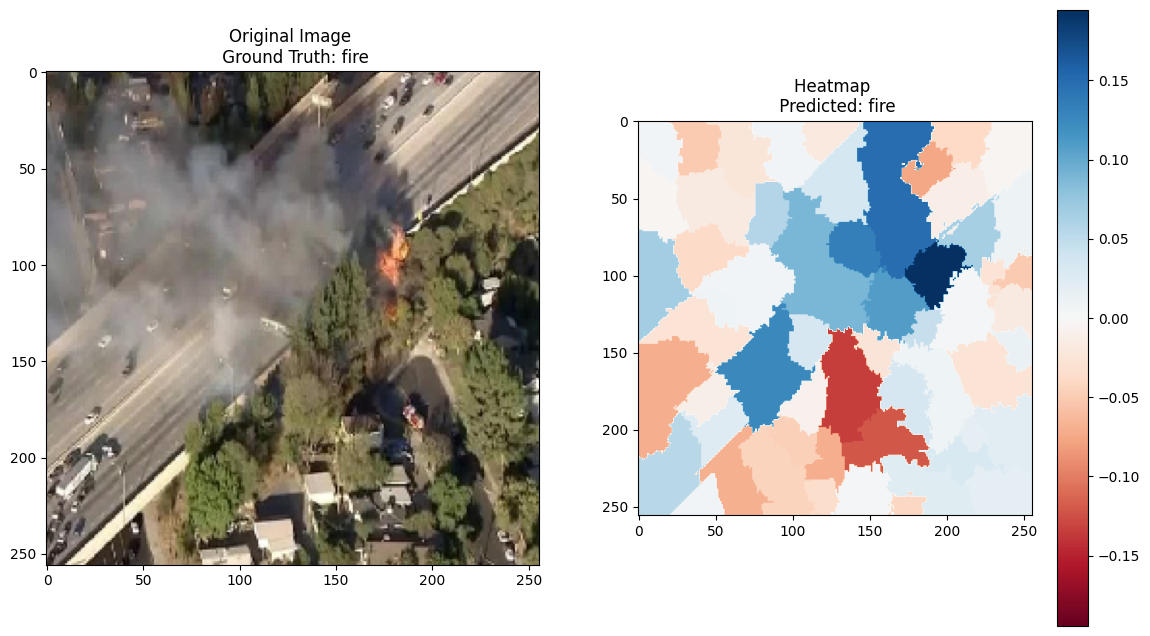

In [31]:
apply_lime(fire_image, np.argmax(test_one_hot[np.argmax(test_one_hot[:, label_encoder.classes_ == 'fire'])]))

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step
Predicted: flooded_areas with 52.71% confidence


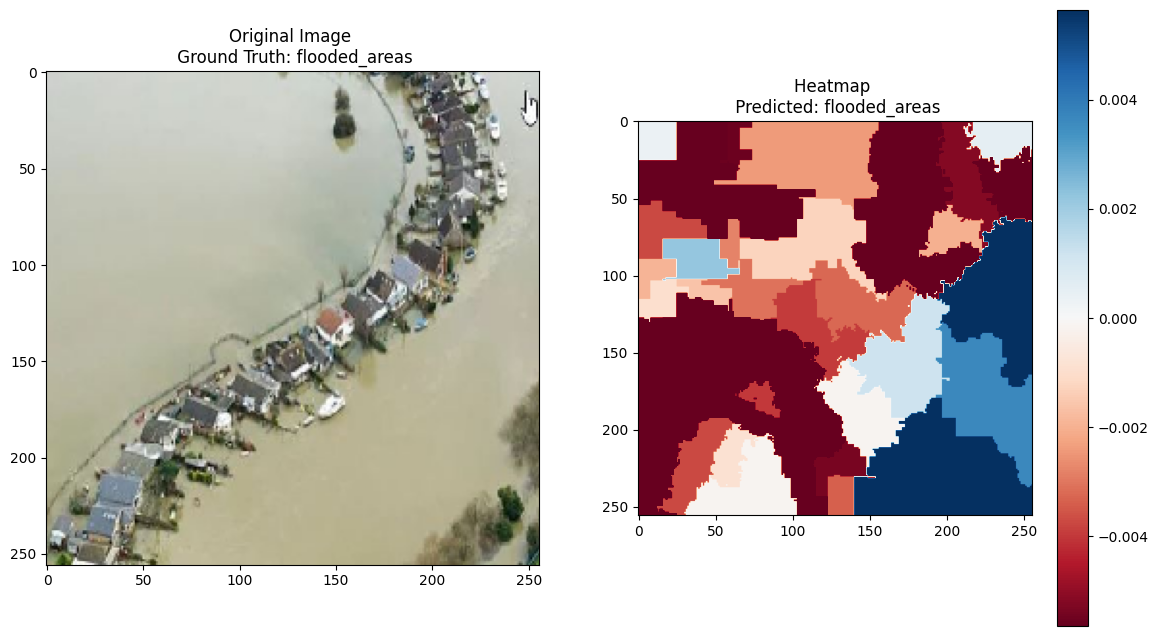

In [32]:
apply_lime(flooded_areas_image, np.argmax(test_one_hot[np.argmax(test_one_hot[:, label_encoder.classes_ == 'flooded_areas'])]))